# Italy Crime Index web scraped in Python
Data scraped from [Il Sole 24 ORE](https://lab24.ilsole24ore.com/indice-della-criminalita/indexT.php) with `BeautifulSoup` library and visualized with `Matplotlib` library (inspired by [Pratap Vardhan](https://towardsdatascience.com/bar-chart-race-in-python-with-matplotlib-8e687a5c8a41)).

### Import the dependent libraries

In [0]:
import collections

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

## Data

Scrape all the tables from [Il Sole 24 ORE](https://lab24.ilsole24ore.com/indice-della-criminalita/indexT.php) with `BeautifulSoup`, store them in a dictionary to create finally a `pandas` DataFrame with every city as *index* and different table names as *columns*.

In [2]:
url = "https://lab24.ilsole24ore.com/indice-della-criminalita/indexT.php"

# Make a GET request to fetch the raw HTML content
html_content = requests.get(url).text

# Parse the html content
soup = BeautifulSoup(html_content, features="html.parser")
# Find all the tables in the HTML
tables = soup.find_all("div", attrs={"class": "grid-item"})

# Initialize a dictionary that will store all the tables
dict_table = collections.defaultdict(dict)
# Get all the headings of tables
headings = []
for tab in tables:
    t_head = tab.find("h2").text.strip()
    headings.append(t_head)
    # Get all the rows of table
    rows = tab.tbody.find_all("tr")
    for row in rows:
        cols = row.find_all("td")
        cols = [x.text.strip() for x in cols][0:4]
        if len(cols) == 4:  # because it is possible that cols is an empty list
            dict_table[t_head][cols[1]] = float(
                cols[3].replace(".", "").replace(",", ".")
            )

dict_table = dict(dict_table)
df = pd.DataFrame.from_dict(dict_table)

df.head(5)

,Classifica finale,Omicidi volontari consumati,Infanticidi,Tentati omicidi,Furti con strappo,Furti con destrezza,Furti in abitazione,Furti in esercizi commerciali,Furti di autovetture,Rapine,Estorsioni,Usura,Associazione per delinquere,Associazione di tipo mafioso,Reciclaggio e impiego di denaro,Truffe e frodi informatiche,Incendi,Stupefacenti,Violenze sessuali
Milano,7017.3,0.4,0.1,1.8,63.2,895.2,430.5,311.1,277.9,101.2,26.1,0.3,1.0,0.0,2.1,523.0,5.5,85.7,14.8
Rimini,6430.1,0.3,0.0,0.6,56.0,764.9,414.1,264.6,59.3,80.2,25.7,0.6,0.0,0.0,2.7,303.8,5.0,88.2,16.2
Firenze,6252.8,0.8,0.0,1.3,37.6,817.3,609.1,307.2,70.1,68.6,14.9,0.1,1.1,0.0,22.0,293.1,7.2,101.2,14.4
Bologna,6233.7,0.4,0.0,1.4,36.5,801.1,536.9,288.9,71.5,67.8,19.5,0.1,0.8,0.0,1.4,411.9,5.1,77.4,14.9
Torino,5339.3,0.4,0.0,1.9,55.7,515.9,419.3,187.6,199.3,79.6,17.0,0.3,0.5,0.0,1.6,418.5,5.0,85.9,9.5


Then create a new column `'Altro'` made by the difference from `'Classifica finale'` and all the other columns, and finally see the *mean* values for every columns in descending order to understand which features have the most impact in the overall ranking.

In [3]:
df.insert(1, "Altro", df.loc[:, headings[0]] - df.loc[:, headings[1:]].sum(axis=1))
df.mean().round(1).sort_values(ascending=False)

Classifica finale                  3434.4
Altro                              2305.1
Furti in abitazione                 308.1
Truffe e frodi informatiche         296.3
Furti con destrezza                 159.8
Furti in esercizi commerciali       120.8
Furti di autovetture                101.7
Stupefacenti                         60.6
Rapine                               30.2
Estorsioni                           15.2
Furti con strappo                    14.3
Incendi                               8.9
Violenze sessuali                     7.5
Reciclaggio e impiego di denaro       2.6
Tentati omicidi                       1.7
Associazione per delinquere           0.7
Omicidi volontari consumati           0.6
Usura                                 0.2
Associazione di tipo mafioso          0.1
Infanticidi                           0.0
dtype: float64

It will be interesting to see the final ranking with all the variables scaled to have the same weight and also scaled only the 18 columns that are the most important crimes. Let's do this by creating a new `pandas` DataFrame and scaling the values with `StandardScaler()` from `scikit-learn` library.

In [4]:
scaler = StandardScaler()
df_scale = df.iloc[:, 1:].copy()

# scale all the values
df_scale[df_scale.columns] = scaler.fit_transform(
    df_scale[df_scale.columns]
)

# insert the ranking calculated by this new values
df_scale.insert(0, headings[0], df_scale.sum(axis=1))
df_scale = df_scale.rename(
    columns={"Classifica finale": "Classifica finale scaled"}
)

# insert the ranking calculated only by the selected 18 columns
df_scale.insert(
    1,
    "Classifica finale scaled No Altro",
    df_scale.loc[:, headings[1:]].sum(axis=1),
)

df_scale.head(5)


,Classifica finale scaled,Classifica finale scaled No Altro,Altro,Omicidi volontari consumati,Infanticidi,Tentati omicidi,Furti con strappo,Furti con destrezza,Furti in abitazione,Furti in esercizi commerciali,Furti di autovetture,Rapine,Estorsioni,Usura,Associazione per delinquere,Associazione di tipo mafioso,Reciclaggio e impiego di denaro,Truffe e frodi informatiche,Incendi,Stupefacenti,Violenze sessuali
Milano,31.736624,28.481694,3.254930,-0.259064,4.096419,0.117683,3.538668,4.187858,0.940008,3.150395,1.342416,3.189015,2.063758,0.178892,0.364209,-0.370812,-0.160197,2.994508,-0.451353,1.132419,2.426870
Rimini,19.057745,15.686465,3.371279,-0.396368,-0.160644,-0.867141,3.018150,3.445887,0.814047,2.380654,-0.323425,2.245873,1.987899,1.143091,-0.990394,-0.370812,0.039970,0.098623,-0.518136,1.245023,2.894169
Firenze,24.700957,22.090653,2.610305,0.290152,-0.160644,-0.292660,1.687935,3.744270,2.311760,3.085836,-0.241124,1.724899,-0.060294,-0.463907,0.499670,-0.370812,6.478677,-0.042737,-0.224290,1.830567,2.293356
Bologna,17.175449,14.546495,2.628954,-0.259064,-0.160644,-0.210591,1.608411,3.652022,1.757222,2.782906,-0.230455,1.688970,0.812085,-0.463907,0.093289,-0.370812,-0.393725,1.526749,-0.504779,0.758572,2.460248
Torino,13.837924,12.127883,1.710041,-0.259064,-0.160644,0.199752,2.996461,2.027998,0.853986,1.106029,0.743444,2.218926,0.337966,0.178892,-0.313092,-0.370812,-0.327002,1.613942,-0.518136,1.141427,0.657809


To better understand the location of every city we need to add a new label based on geographical area division [NUTS 1](https://it.m.wikipedia.org/wiki/Nomenclatura_delle_unit%C3%A0_territoriali_per_le_statistiche_dell%27Italia) created by [Eurostat](https://it.m.wikipedia.org/wiki/Eurostat). So we loaded a file `nuts_italy.csv` stored on [GitHub](https://gist.githubusercontent.com/giampaolocasolla/85a35332168c217d4068a6638bb9a7d9/raw/a2b0d1b5d3b528e0b8b7c89e886b17e6bca36983/nuts_italy.csv) created by [this site](https://wikitable2csv.ggor.de/) to get a dictionary with every cities linked to their NUTS 1.

For this project we only need 2 columns to work with `'NUTS 1', 'NUTS 3'`.

In [0]:
url_nuts = 'https://gist.githubusercontent.com/giampaolocasolla/85a35332168c217d4068a6638bb9a7d9/raw/a2b0d1b5d3b528e0b8b7c89e886b17e6bca36983/nuts_italy.csv'
dict_nuts = pd.read_csv(url_nuts).set_index("NUTS 3")["NUTS 1"].to_dict()

# insert a new column to df_scale that will be necessary later
df_scale.insert(2, "nuts", list(df_scale.index.map(dict_nuts)))

## Ranking

Now we create a function to generate a specific DataFrame for future plots.

The DataFrame need all the necessary labels and only the *Top 10* and *Last 10* elements.

In [0]:
def create_df_plot(df, col, dict_nuts, numb=10):
  # select the Top 10 elements and the Last 10 elements from the original DataFrame
    df_plot_1 = (
        df.loc[:, col]
        .sort_values(ascending=False)
        .iloc[np.arange(numb).tolist() + np.arange(len(df) - numb, len(df)).tolist()]
        .copy()
        .to_frame()
    )
    df_plot_1.reset_index(level=0, inplace=True)
    df_plot_1 = df_plot_1.rename(columns={"index": "name"})
    # add a new column with NUTS values from the dictionary created early
    df_plot_1["nuts"] = df_plot_1["name"].map(dict_nuts)
    # flip values from top to bottom
    df_plot_1 = df_plot_1[::-1]
    # add a new column with labels
    df_plot_1["rank"] = [col] * (numb*2)
    df_plot_1 = df_plot_1.rename(columns={col: "value"})
    return df_plot_1

Generate a single DataFrame `df_plot` that is created from the function `create_df_plot()` above, cycled 3 times for every different ranking.

In [7]:
appended_data = []
for d, c in zip(
    [df, df_scale, df_scale],
    [
        "Classifica finale",
        "Classifica finale scaled",
        "Classifica finale scaled No Altro",
    ],
):
    data = create_df_plot(d, c, dict_nuts)
    # store DataFrame in list
    appended_data.append(data)
# merge all the stored DataFrames
df_plot = pd.concat(appended_data)

df_plot.head(5)

,name,value,nuts,rank
19,Oristano,1493.3,Isole,Classifica finale
18,Pordenone,2125.9,Nord-Est,Classifica finale
17,Benevento,2138.5,Sud,Classifica finale
16,Potenza,2216.1,Sud,Classifica finale
15,Sondrio,2239.7,Nord-Ovest,Classifica finale


We'll use `colors` to add color to the bars.

In [0]:
colors = dict(
    zip(
        ["Nord-Ovest", "Nord-Est", "Centro", "Sud", "Isole"],
        ["#adb0ff", "#ffb3ff", "#90d595", "#e48381", "#aafbff"],
    )
)

Create a function `draw_barchart()` to generate a single horizontal bar plot, styling the following items:

- Text: font sizes, color, orientation, position based on values
- Format: comma separated values and axes tickers
- Axis: Move to top, color, add subtitle
- Grid: Add lines behind bars
- Remove box frame
- Add title, credit

In [0]:
def draw_barchart(
    type_rank, group_lk, title_plot, subtitle_plot, scaled=False, dx=None
):
    dff = df_plot[df_plot["rank"] == type_rank].sort_values(by="value", ascending=True)
    ax.clear()
    ax.barh(dff["name"], dff["value"], color=[colors[group_lk[x]] for x in dff["name"]])
    if dx is None:
        dx = dff["value"].max() / 200
    for i, (value, name) in enumerate(zip(dff["value"], dff["name"])):
        # text inside bars
        if value > 0:
            ax.text(value - dx, i, name, size=14, weight=600, ha="right", va="bottom")
            ax.text(
                value - dx,
                i - 0.25,
                group_lk[name],
                size=10,
                color="#444444",
                ha="right",
                va="baseline",
            )
            if not scaled:
                ax.text(value + dx, i, f"{value:,.0f}", size=14, ha="left", va="center")
        else:
            ax.text(value + dx, i, name, size=14, weight=600, ha="left", va="bottom")
            ax.text(
                value + dx,
                i - 0.25,
                group_lk[name],
                size=10,
                color="#444444",
                ha="left",
                va="baseline",
            )
            if not scaled:
                ax.text(
                    value - dx, i, f"{value:,.0f}", size=14, ha="right", va="center"
                )
    # ... polished styles
  
    # Top 10
    ax.text(
        1,
        0.7,
        "Top 10",
        transform=ax.transAxes,
        color="#777777",
        size=35,
        ha="right",
        weight=800,
    )
    # Last 10
    ax.text(
        1,
        0.3,
        "Last 10",
        transform=ax.transAxes,
        color="#777777",
        size=35,
        ha="right",
        weight=800,
    )
    # Subtitle plot
    ax.text(0, 1.06, subtitle_plot, transform=ax.transAxes, size=12, color="#777777")
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
    ax.xaxis.set_ticks_position("top")
    ax.tick_params(axis="x", colors="#777777", labelsize=12)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which="major", axis="x", linestyle="-")
    ax.set_axisbelow(True)
    # Title plot
    ax.text(0, 1.12, title_plot, transform=ax.transAxes, size=24, weight=600, ha="left")
    # Author, credit
    ax.text(
        1,
        0,
        "by @giampaolocasolla; credit @pratapvardhan",
        transform=ax.transAxes,
        ha="right",
        color="#777777",
        bbox=dict(facecolor="white", alpha=0.8, edgecolor="white"),
    )
    # remove box frame
    plt.box(False)

### Figure 1

Use the function `draw_barchart()` to generate the first Figure, made by *Total number of crimes 'emerged' for every 100,000 inhabitants*.

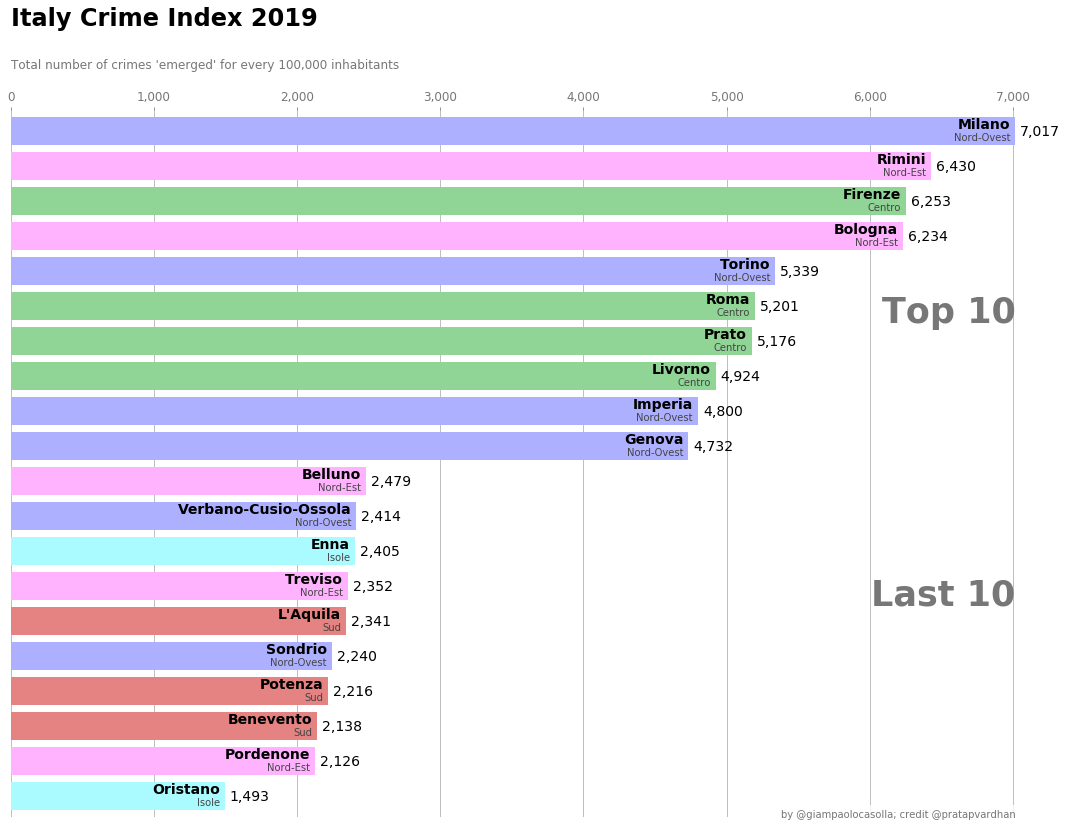

In [10]:
fig, ax = plt.subplots(figsize=(18, 13))
draw_barchart(
    "Classifica finale",
    dict_nuts,
    title_plot="Italy Crime Index 2019",
    subtitle_plot="Total number of crimes 'emerged' for every 100,000 inhabitants",
    scaled=False,
)

### Figure 2

Use the function `draw_barchart()` to generate the second Figure, made by *Total number of crimes 'emerged' for every 100,000 inhabitants scaled by every types of crime*.

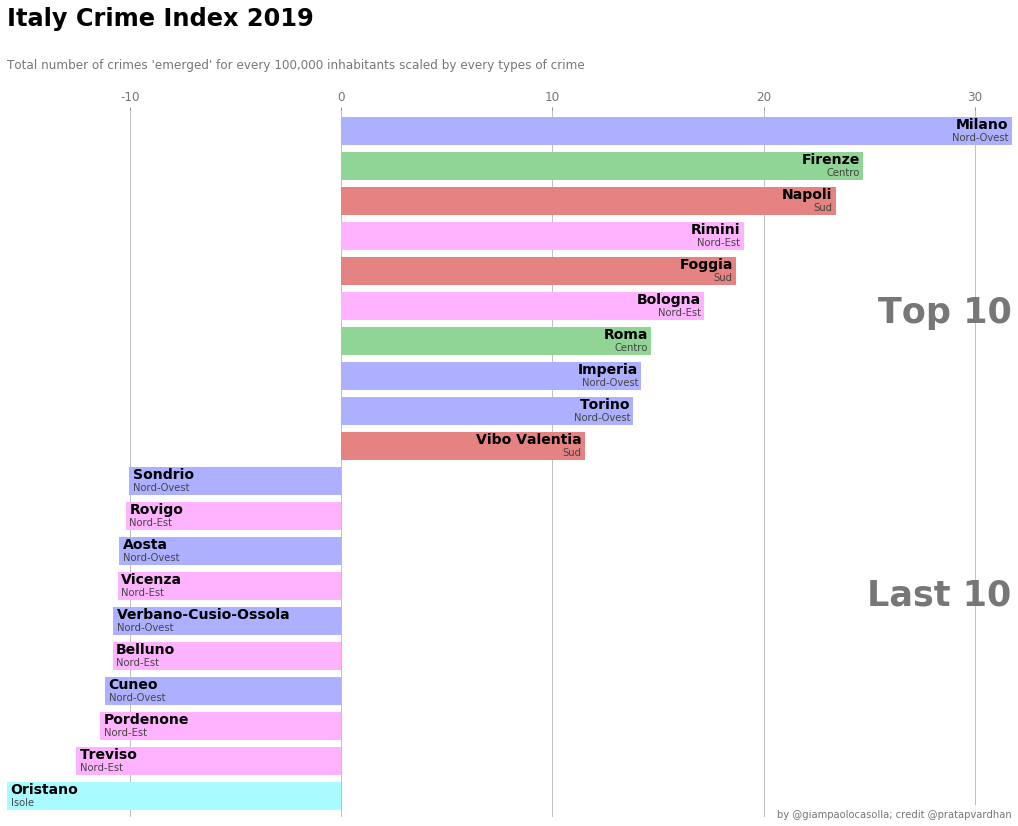

In [11]:
fig, ax = plt.subplots(figsize=(18, 13))
draw_barchart(
    "Classifica finale scaled",
    dict_nuts,
    title_plot="Italy Crime Index 2019",
    subtitle_plot="Total number of crimes 'emerged' for every 100,000 inhabitants scaled by every types of crime",
    scaled=True,
)

###Figure 3

Use the function `draw_barchart()` to generate the third Figure, made by *Total number of crimes 'emerged' for every 100,000 inhabitants scaled only by selected 18 types of crime*.

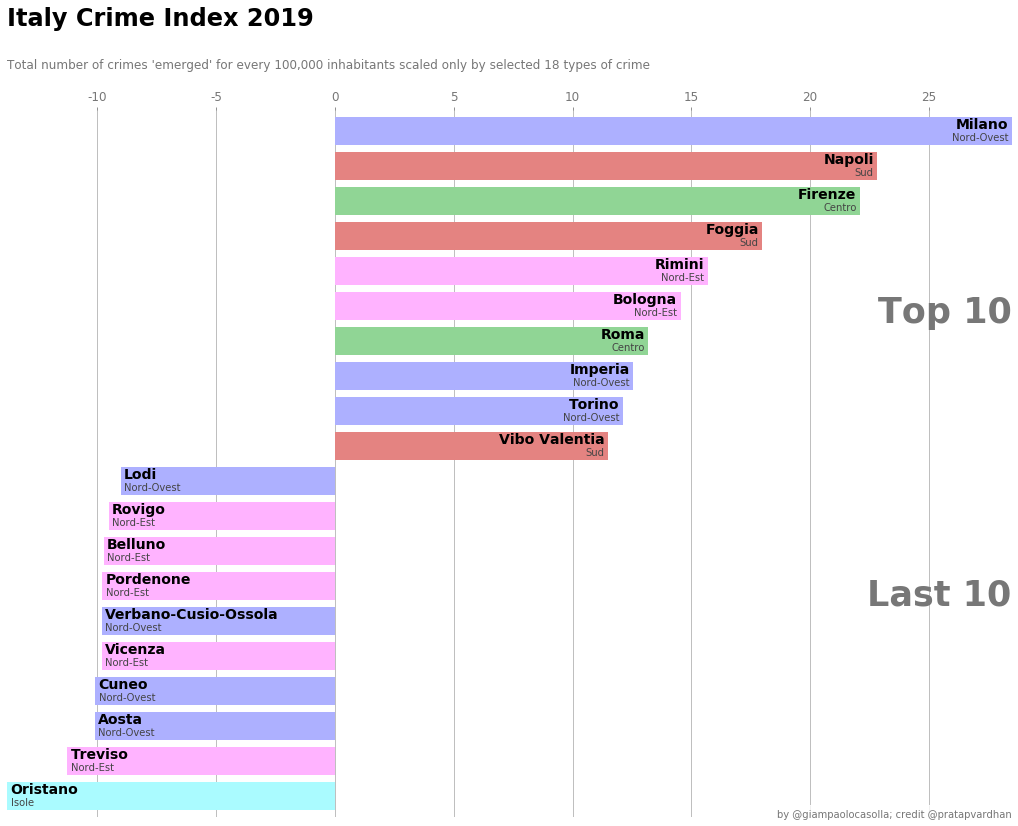

In [12]:
fig, ax = plt.subplots(figsize=(18, 13))
draw_barchart(
    "Classifica finale scaled No Altro",
    dict_nuts,
    title_plot="Italy Crime Index 2019",
    subtitle_plot="Total number of crimes 'emerged' for every 100,000 inhabitants scaled only by selected 18 types of crime",
    scaled=True,
)

## Unsupervised Learning

Unsupervised learning is a type of self-organized Hebbian learning that helps find previously unknown patterns in data set without pre-existing labels.

### 2-D representation

Let's start to visualize our `df_scale` DataFrame in 2 dimensions with `t-SNE` algorithm and `PCA` creating a function  `plot_projections()`.

In [0]:
def plot_projections(
    df, # starting DataFrame
    which=None, # which algoritm to use
    groups_dict=None, # dictionary of mapping elements to groups
    groups_num=None, # how many groups are there
    colors=None, # dictionary of colors
    clusters=None, # list of clusters
):
    import warnings

    if which == "t-SNE": # t-SNE algorithm
        from sklearn.manifold import TSNE
        import time

        time_start = time.time()
        tsne = TSNE(n_components=2, perplexity=10, learning_rate=100, verbose=1)
        results = tsne.fit_transform(df)[:, 0:2]

        print("t-SNE done! Time elapsed: {} seconds".format(time.time() - time_start))

    elif which == "PCA": # PCA algorithm
        from sklearn.decomposition import PCA

        pca = PCA(n_components=2)
        results = pca.fit_transform(df)[:, 0:2]
        print(
            "Explained variation per principal component: {}".format(
                pca.explained_variance_ratio_
            )
        )
    else:
        warnings.warn("Select TSNE or PCA")

    # create a DataFrame for the plot
    df_plt = pd.DataFrame(results, columns=["one", "two"])
    if clusters is None:
        df_plt["label"] = list(df.index.map(groups_dict))
    else:
        df_plt["label"] = clusters

    if groups_num is None:
        groups_num = len(set(df_plt["label"])) # count the number of different groups

    sns.set()
    sns.set_context("notebook", font_scale=1.3)
    fig, ax = plt.subplots(figsize=(13, 6))
    sns.scatterplot(
        x="one",
        y="two",
        hue="label",
        style="label",
        palette=colors,
        data=df_plt,
        legend="full",
        alpha=1,
        s=70,
    )
    # title
    ax.text(0, 1.05, which, transform=ax.transAxes, size=24, weight=600, ha="left")
    # author
    ax.text(
        1,
        0,
        "by @giampaolocasolla",
        transform=ax.transAxes,
        ha="right",
        color="#777777",
        bbox=dict(facecolor="white", alpha=0.8, edgecolor="white"),
    )

#### t-SNE

Use the function `plot_projections()` to generate 2-D representation of the `df_scale` DataFrame with `t-SNE` algorithm and colors varying by `NUTS 1`.

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 106 samples in 0.000s...
[t-SNE] Computed neighbors for 106 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 106 / 106
[t-SNE] Mean sigma: 1.384785
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.554306
[t-SNE] KL divergence after 1000 iterations: 0.712590
t-SNE done! Time elapsed: 0.5062389373779297 seconds


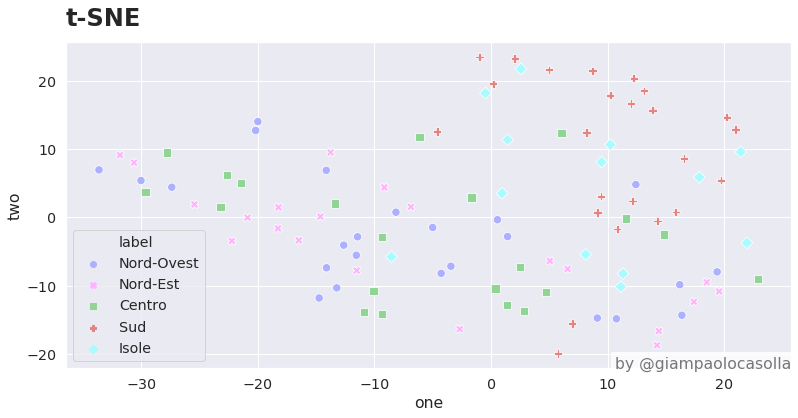

In [18]:
plot_projections(
    df_scale[df_scale.columns[3:]],
    which="t-SNE",
    groups_dict=dict_nuts,
    colors=colors,
)

#### PCA

Use the function `plot_projections()` to generate 2-D representation of the `df_scale` DataFrame with `PCA` algorithm and colors varying by `NUTS 1`.

Explained variation per principal component: [0.27665574 0.18758478]


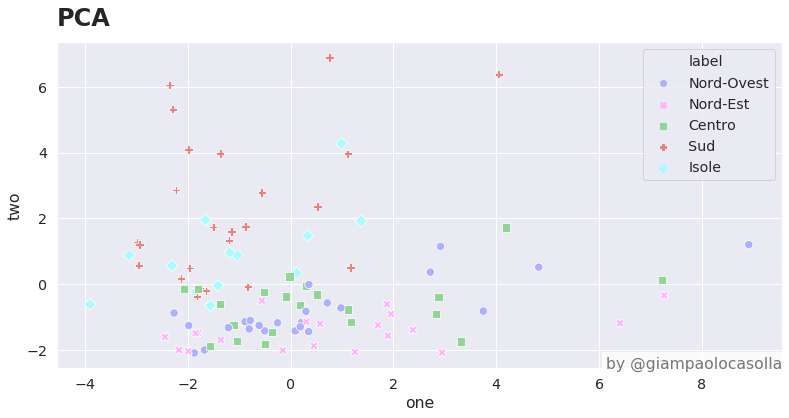

In [15]:
plot_projections(
    df_scale[df_scale.columns[3:]],
    which="PCA",
    groups_dict=dict_nuts,
    colors=colors,
)

### Clustering

In order to retrive insights from our data we need to group them with a clustering algorithm.

Clustering algorithms seek to learn, from the properties of the data, an optimal division in groups of points (cities in our case).

The first phase is to choose the appropriate number of groups, also known as *k* value.

For this task I switched to **R** to use a modified version of `NbClust()` function that cycle through various indices and clustering methods from *k*=2 to *k*=10 and select the choosen *k* for every indices.

An *ensemble* approach through a *voting* technique has been used.

The result is *k*=3 as can be seen in the following figure.

![](https://drive.google.com/uc?id=15JmsSaIiY1WaGlhHg0c3v9HDMfAM3LpJ)


#### *k*-Means

The *k*-Means algorithm searches for a pre-determined number of clusters within an unlabeled multidimensional dataset.

We use the function `KMeans()` from the `sklearn.cluster` library.

In [20]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(df_scale.iloc[:, 3:])

# insert the results of the clustering in df_scale DataFrame
df_scale.insert(3, "cluster", kmeans.labels_)

ValueError: ignored

With the results of the *k*-Means algorithm create a new DataFrame containing all the cities varying by clusters. 

In [30]:
# Initialize a dictionary that will store all the tables
dict_clusters = collections.defaultdict(list)
# loop through the df_scale DataFrame
for index, row in df_scale.iterrows():
    dict_clusters[row["cluster"]].append(index)
dict_clusters = dict(dict_clusters)

# generate a new DataFrame from the created dictionary
df_list = pd.DataFrame.from_dict(dict_clusters, orient='index').transpose().fillna("")

# print all the rows of the DataFrame
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df_list)

,2,0,1
0,Milano,Napoli,Massa-Carrara
1,Rimini,Foggia,Lucca
2,Firenze,Bari,Grosseto
3,Bologna,Catania,Pavia
4,Torino,Siracusa,Forlì-Cesena
5,Roma,Palermo,Pescara
6,Prato,Catanzaro,La Spezia
7,Livorno,Salerno,Pistoia
8,Imperia,Caserta,Reggio Emilia
9,Genova,Barletta-Andria-Trani,Perugia


Let's see the clusters distribution based on `NUTS 1` from the results of *k*-Means algorithm by a *grouped bar plot*.

From the following figure is interesting to see a big cluster with cities from all `NUTS 1`, but the other two clusters very well splitted among them.

Text(0, 0.97, 'by @giampaolocasolla')

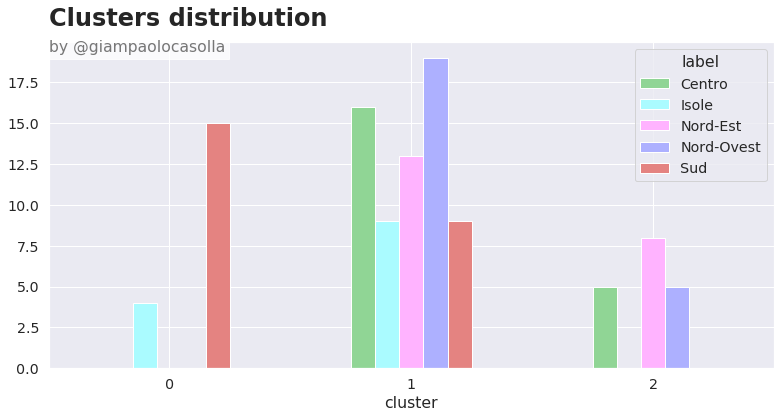

In [22]:
# create a new DataFrame for the plot with some data manipulations 
df_bar = df_scale.groupby("nuts").cluster.value_counts().unstack(0)
df_bar.columns.name = "label"

fig, ax = plt.subplots(figsize=(13, 6))
sns.set()
sns.set_context("notebook", font_scale=1.3)
df_bar.plot(kind="bar", color=[colors[x] for x in df_bar.columns], ax=ax)
plt.xticks(rotation=0)
ax.text(0, 1.05, "Clusters distribution", transform=ax.transAxes, size=24, weight=600, ha="left")
ax.text(
    0,
    0.97,
    "by @giampaolocasolla",
    transform=ax.transAxes,
    ha="left",
    color="#777777",
    bbox=dict(facecolor="white", alpha=0.8, edgecolor="white"),
)
plt.show()

#### PCA with clusters

Use the function `plot_projections()` to generate 2-D representation of the `df_scale` DataFrame with `PCA` algorithm and colors varying by `cluster`.

Explained variation per principal component: [0.27665574 0.18758478]


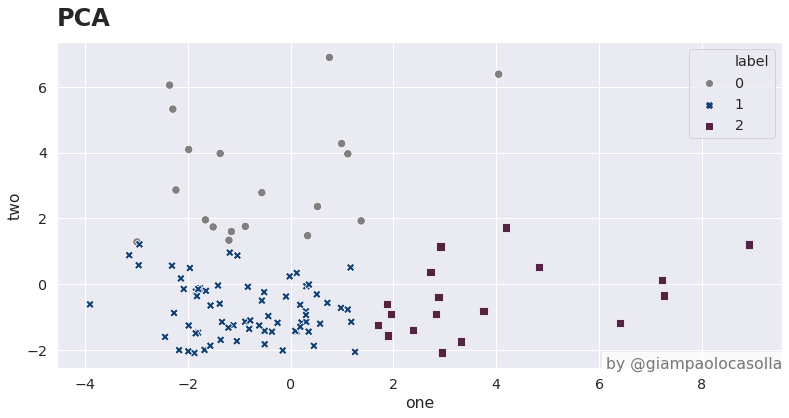

In [21]:
plot_projections(
    df_scale[df_scale.columns[4:]],
    which="PCA",
    groups_dict=dict_nuts,
    colors={0: "#808080", 1: "#134074", 2: "#542344"},
    clusters=df_scale["cluster"].to_list(),
)

#### Features analysis

Rearrange `df_scale` DataFrame to create a *grouped horizontal box plot* so that the values of every column goes to a single column with `melt()` function.

In [0]:
df_analysis = pd.melt(
    df_scale, id_vars=["cluster"], value_vars=df_scale.columns[4:], var_name="feature"
)

Let's see a *box plot* representation for all the features varying on `cluster` from the results of *k*-Means algorithm.

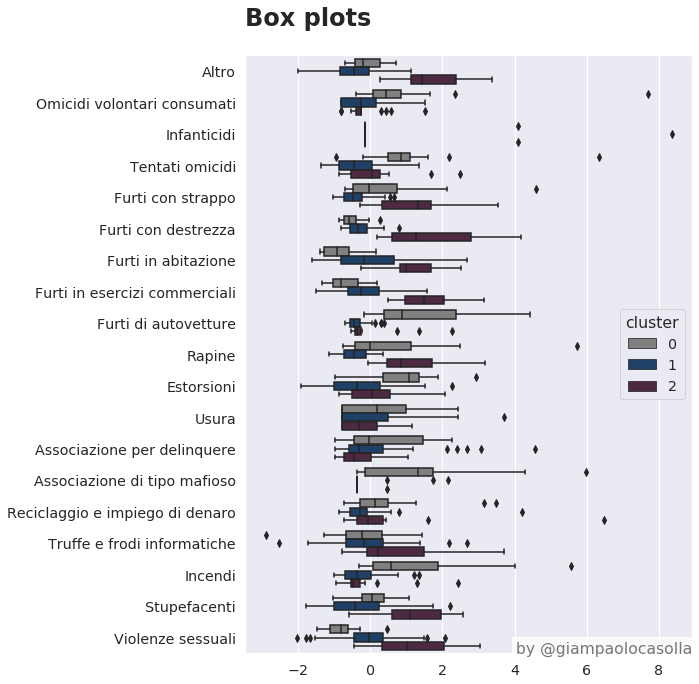

In [34]:
fig, ax = plt.subplots(figsize=(8, 11))
sns.set()
sns.set_context("notebook", font_scale=1.3)
sns.boxplot(
    x="value",
    y="feature",
    data=df_analysis,
    palette={0: "#808080", 1: "#134074", 2: "#542344"},
    hue="cluster",
    orient="h",
)
ax.text(0, 1.05, "Box plots", transform=ax.transAxes, size=24, weight=600, ha="left")
ax.text(
    1,
    0,
    "by @giampaolocasolla",
    transform=ax.transAxes,
    ha="right",
    color="#777777",
    bbox=dict(facecolor="white", alpha=0.8, edgecolor="white"),
)
plt.legend(title="cluster", loc="center right")
plt.xlabel("")
plt.ylabel("")
plt.show()

## Results

From the last figure it's possible to notice that:

- the bigger cluster is made by cities that have *mean* values in every types of crime (like a **baseline**). 
- the cluster made by cities from `Nord-Ovest, Nord-Est, Centro` have **extremely high** values in `'Altro', 'Furti con strappo', 'Furti con destrezza', 'Furti in abitazione', 'Furti in esercizi commerciali', 'Rapine', 'Truffe e frodi informatiche', 'Stupefacenti', 'Violenze sessuali'`.
- the cluster made by cities from `Sud, Isole` have **extremely high** values in `Omicidi volontari consumati', 'Tentati omicidi', 'Furti di autovetture', 'Estorsioni', 'Usura', 'Associazione per delinquere', 'Associazione di tipo mafioso', 'Incendi'` and **extremely low** values in `'Furti in abitazione', 'Furti in esercizi commerciali', 'Violenze sessuali'`.